## 04 MSM Analysis

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Author: [Antonia Mey -- @ppxasjsm](https://github.com/ppxasjsm)

## Learning objectives:

- Be able to identify the timescale of the slowest process
- Be able to reweight the free energy surface according to the stationary distribution
- Learn how to identify active sets
- Plot right eigenvectors and identify different processes

You will be using the following functionalities in pyemma:

- the `active_state_fraction`, `active_count_fraction`, and `active_set` attributes of an MSM object to see how much (and which parts) of our data form the largest connected set represented by the MSM,
- the `stationary_distribution` (or `pi`) attribute of an MSM object to access its stationary vector,
- the `eigenvectors_right()` method of an MSM object to access its (right) eigenvectors,

For visualizing MSMs or kinetic networks we used
- `pyemma.plots.plot_density()`
- `pyemma.plots.plot_contour()` and
- `pyemma.plots.plot_cktest()`.


**Reading time**:
~ x mins

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

 

## Table of Contents
1. [Recap, loading and estimating MSM](#recap)    
2. [Slowest process](#slow)   
3. [Stationary distribution](#pi)   
4. [Eigenvectors](#ev)   
5. [Exercises](#exerc)   

## 1. Recap, loading and estimating MSM
<a id="recap"></a>

#### Let's get all the necessary imports out of the way

In [22]:
%pylab inline
import mdshare
import pyemma

Populating the interactive namespace from numpy and matplotlib


/Users/toni_brain/miniconda3/envs/pyemma/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We fetch the alanine dipeptide data set, load the backbone torsions into memory,
directly discretize the full space using $k$-means clustering,
visualize the margial and joint distributions of both components as well as the cluster centers,
and show the ITS convergence to help selecting a suitable lag time:

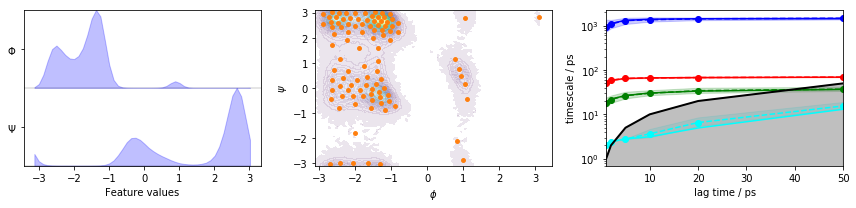

In [23]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

cluster = pyemma.coordinates.cluster_kmeans(data, k=100, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data), feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$\phi$')
axes[1].set_ylabel('$\psi$')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

The plots show us the marginal (left panel) and joint distributions along with the cluster centers (middle panel).
The implied timescales are converged (right panel). 

Before we proceed, let's have a look at the implied timescales error bars.
They were computed from a Bayesian MSM, as requested by the `errors='bayes'` argument of the `pyemma.msm.its()` function.
As mentioned before, Bayesian MSMs incorporate a sample of transition matrices.
Target properties such as implied timescales can now simply be computed from the individual matrices.
Thereby, the posterior distributions of these properties can be estimated.
The ITS plot shows a confidence interval that contains $95\%$ of the Bayesian samples.

In [24]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, conf=0.95)

## 2. Slowest process
<a id="slow"></a>

For any PyEMMA method that derives target properties from MSMs, sample mean and confidence intervals (as defined by the function argument above) are directly accessible with  `sample_mean()` and `sample_conf()`.
Further, `sample_std()` is available for computing the standard deviation.
In the more general case, it might be interesting to extract the full sample of a function evaluation with `sample_f()`.
The syntax is equivalent for all those functions.

In [25]:
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))

Mean of first ITS: 1446.294413
Confidence interval: [1289.958997, 1671.062985]


Please note that sample mean and maximum likelihood estimates are not identical and generally do not provide numerically identical results.

Now, for the sake of simplicity we proceed with the analysis of a maximum likelihood MSM.
We estimate it at lag time $10$ ps...

In [26]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10)

## 3. Connectivity
<a id="conn"></a>

... and check for disconnectivity.
The MSM is constructed on the largest set of discrete states that are (reversibly) connected.
The `active_state_fraction` and `active_count_fraction` show us the fraction of discrete states and transition counts from our data which are part of this largest set and, thus, used for the model:

In [29]:
print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


The fraction is, in both cases, $1$ and, thus, we have no disconnected states (which we would have to exclude from our analysis).

If there were any disconnectivities in our data (fractions $<1$),
we could access the indices of the **active states** (members of the largest connected set) via the `active_set` attribute:

In [30]:
print(msm.active_set)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


## 4. Stationary distribution
<a id="pi"></a>

With this potential issue out of the way, we can extract our first (stationary/thermodynamic) property,
the `stationary_distribution` or, as a shortcut, `pi`:

In [31]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))

[0.01206867 0.01169543 0.00851303 0.00580575 0.02130901 0.00904763
 0.01847472 0.01060419 0.00407856 0.00643655 0.02062356 0.00325803
 0.01340794 0.00909458 0.00706334 0.00800804 0.00605235 0.01559936
 0.0050921  0.01105597 0.01122601 0.00720454 0.01800655 0.00147641
 0.00080555 0.01476314 0.01293576 0.00018805 0.01864141 0.00598037
 0.0107898  0.00319648 0.00723242 0.01287174 0.0036817  0.00574157
 0.01224497 0.00804553 0.00959199 0.00404196 0.01174595 0.00571771
 0.0054586  0.01513781 0.0214518  0.01163264 0.01316674 0.01285706
 0.02117173 0.00602103 0.01434557 0.02050485 0.01272911 0.00467632
 0.01515916 0.00012404 0.00600821 0.01280305 0.01400505 0.01453487
 0.00271542 0.00551364 0.01308395 0.01743807 0.01166511 0.01437348
 0.01395218 0.01633686 0.01769176 0.00833852 0.00581442 0.00874628
 0.01464041 0.00632714 0.00052147 0.0022094  0.00749013 0.0044519
 0.01381204 0.00488677 0.00822496 0.00970593 0.00759926 0.00912774
 0.00907687 0.00574038 0.00625786 0.00593202 0.01471231 0.01043

The attribute `msm.pi` tells us, for each discrete state, the absolute probability of observing said state in global equilibrium.
Mathematically speaking, the stationary distribution $\pi$ is the left eigenvector of the transition matrix $\mathbf{P}$ to the eigenvalue $1$:

$$\pi^\top \mathbf{P} = \pi^\top.$$

Please note that the $\pi$ is fundamentaly different from a normalized histogram of states:
for the histogram of states to accurately describe the stationary distribution, the data needs to be sampled from global equilibrium, i.e, the data points need to be statistically independent.
The MSM approach, on the other hand, only requires local equilibrium, i.e., statistical independence of state transitions.
Thus, the MSM approach requires a much weaker and, in practice, much easier to satisfy condition than simply counting state visits.

We can use the stationary distribution to, e.g., visualize the weight of the dicrete states and, thus, to highlight which areas of our feature space are most probable.
Here, we show all data points in a two dimensional scatter plot and color/weight them according to their discrete state membership:

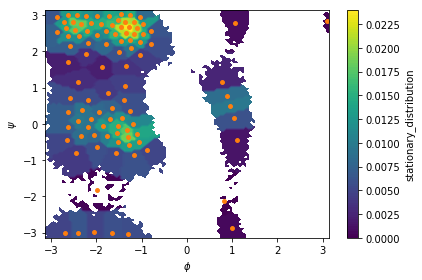

In [32]:
fig, ax, misc = pyemma.plots.plot_contour(
    *data_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
fig.tight_layout()

The stationary distribution can also be used to correct the `pyemma.plots.plot_free_energy()` function that we used to visualize.
This might be necessary if the data points are not sampled from global equilibrium.

In this case, we assign the weight of the corresponding discrete state to each data point and pass this information to the plotting function via its `weights` parameter:

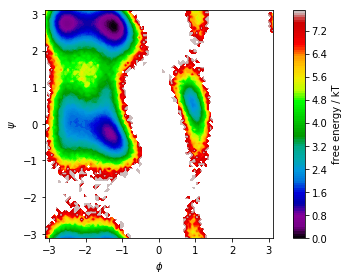

In [33]:
fig, ax, misc = pyemma.plots.plot_free_energy(
    *data_concatenated.T,
    weights=np.concatenate(msm.trajectory_weights()),
    legacy=False)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
ax.set_aspect('equal')
fig.tight_layout()

## 5. Right eigenvectors
<a id="ev"></a>

We will see further uses of the stationary distribution later.
But for now, we continue the analysis of our model by visualizing its (right) eigenvectors which encode the dynamical processes.
First, we notice that the first right eigenvector is a constant $1$.

In [34]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: True (min=0.9999999999996662, max=1.0000000000000118)


Next, we visualize the first six right eigenvectors:

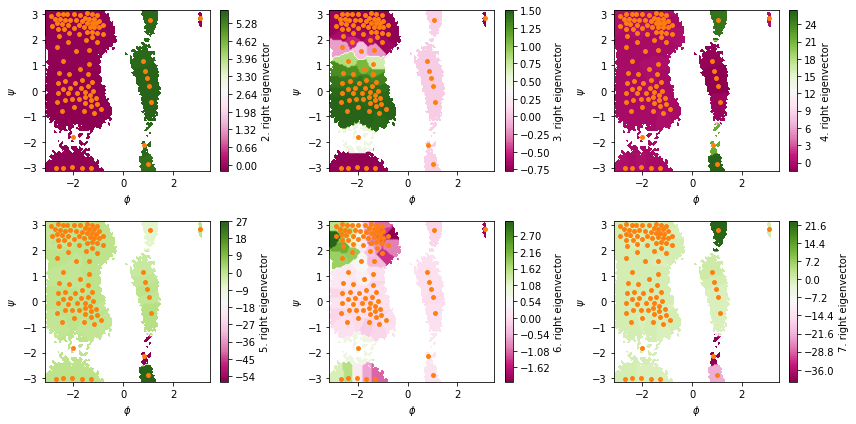

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data_concatenated.T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
fig.tight_layout()

We have the $(1,\dots,1)^\top$ first right eigenvector of the stationary process.

The second to fourth right eigenvectors illustrate the three slowest processes which are (in that order):

- rotation of the $\phi$ dihedral,
- rotation of the $\psi$ dihedral when $\phi\approx-2$ rad, and
- rotation of the $\psi$ dihedral when $\phi\approx1$ rad.

Eigenvectors five, six, and seven indicate further processes which, however, relax faster than the lag time and cannot be resolved clearly.

We now proceed our validation process using a Bayesian MSM with four metastable states:

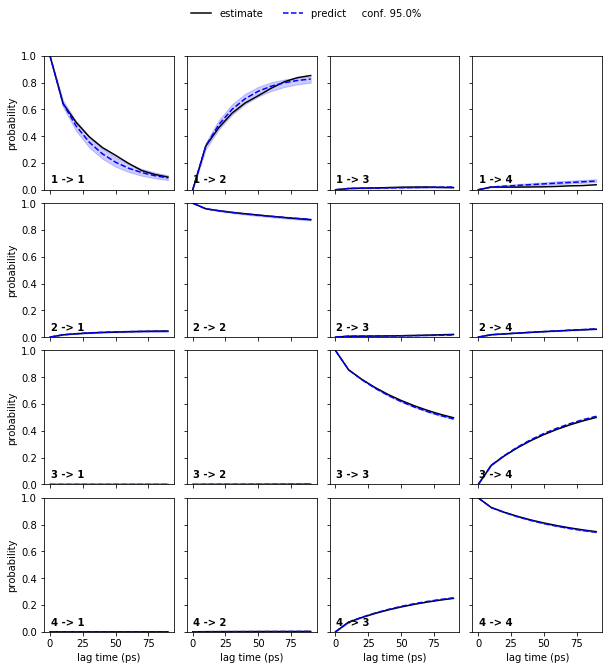

In [36]:
nstates = 4
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')
pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps');

We note that four metastable states are a reasonable choice for our MSM.

In general, the number of metastable states is a modeler's choice; it is adjusted to map the kinetics to be modeled.
In the current example, increasing the resolution with a higher number of metastable states or resolving only the slowest process between $2$ states would be possible.
However, the number of states is not arbitrary as the observed processes in metastable state space need not be Markovian in general.
A failed Chapman-Kolmogorov test can thus also hint to a bad choice of the metastable state number.

In order to perform further analysis, we save the model to disk:

In [37]:
cluster.save('nb4.pyemma', model_name='ala2_cluster', overwrite=True)
msm.save('nb4.pyemma', model_name='ala2_msm', overwrite=True)
bayesian_msm.save('nb4.pyemma', model_name='ala2_bayesian_msm', overwrite=True)

/Users/toni_brain/miniconda3/envs/pyemma/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


## 6. Exercises
<a id="exerc"></a>

#### Exercise 6.1
Load the heavy atom distances into memory, TICA (`lag=3` and `dim=2`), discretize with  100 $k$-means centers and a stride of $10$, and show the ITS convergence.

In [ ]:
feat = #FIXME
feat. #FIXME
data = #FIXME

tica = #FIXME
tica_concatenated = #FIXME

cluster = #FIXME
dtrajs_concatenated = #FIXME

its = #FIXME

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(tica_concatenated, feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

###### Solution

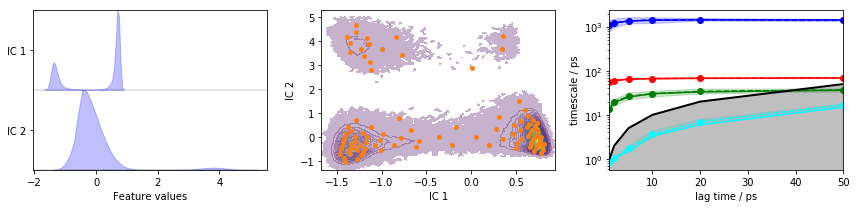

In [38]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

tica = pyemma.coordinates.tica(data, lag=3, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(tica_concatenated, feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

#### Exercise 6.2
Estimate an MSM at lag time $10$ ps with `dt_traj='1 ps'` and visualize the stationary distribution using a two-dimensional colored scatter plot of all data points in TICA space.

In [ ]:
msm = #FIXME

print('fraction of states used = {:f}'. #FIXME
print('fraction of counts used = {:f}'. #FIXME

fig, ax, misc = pyemma.plots.plot_contour(
    *tica_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

###### Solution

fraction of states used = 1.000000
fraction of counts used = 1.000000


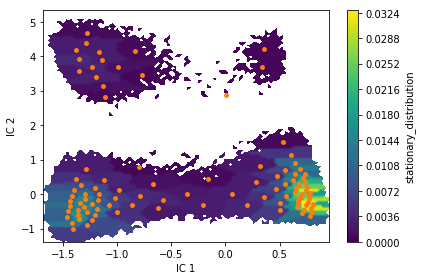

In [39]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *tica_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

#### Exercise 5.3
Visualize the first six right eigenvectors.

In [ ]:
eigvec = #FIXME
print('first eigenvector is one: {} (min={}, max={})'.format( #FIXME

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour( #FIXME )
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

###### Solution

first eigenvector is one: True (min=0.999999999999967, max=1.0000000000000047)


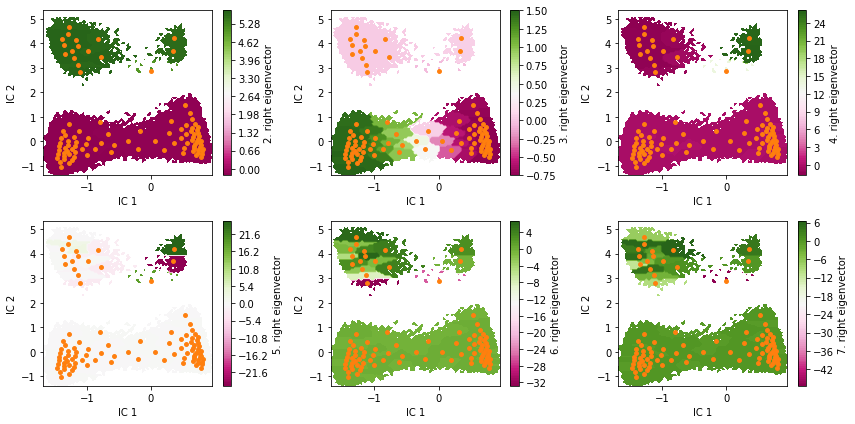

In [40]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

Can you already guess from eigenvectors two to four which the metastable states are?

#### Exercise 5.4
Estimate a Bayesian MSM at lag time $10$ ps and perform/show a CK test for four metastable states.

In [ ]:
bayesian_msm = #FIXME

nstates = 4
pyemma.plots. #FIXME

###### Solution

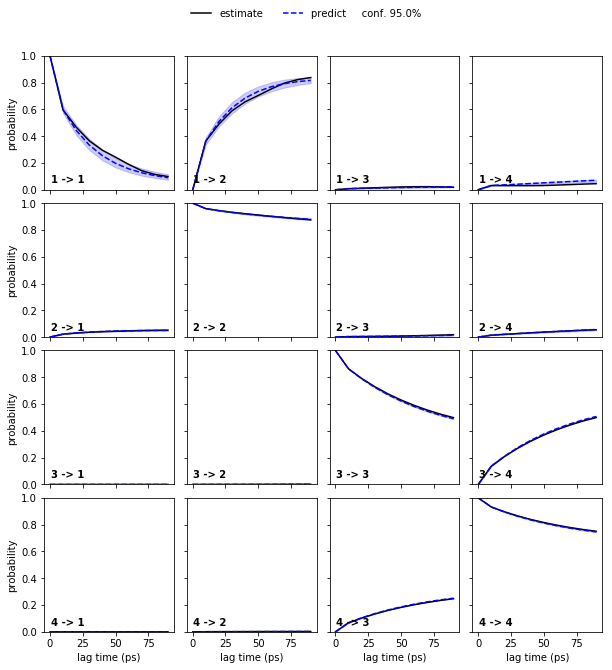

In [41]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

nstates = 4
pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps');

#### Exercise 5.5
Save the MSM, Bayesian MSM and Cluster objects to the same file as before.
Use the model names `ala2tica_msm`, `ala2tica_bayesian_msm` and `ala2tica_cluster`, respectively.
Further, include the TICA object with model name `ala2tica_tica`.

In [ ]:
#FIXME 

###### Solution

In [44]:
cluster.save('nb4_e.pyemma', model_name='ala2tica_cluster', overwrite=True)
msm.save('nb4_e.pyemma', model_name='ala2tica_msm', overwrite=True)
bayesian_msm.save('nb4_e.pyemma', model_name='ala2tica_bayesian_msm', overwrite=True)
tica.save('nb4_e.pyemma', model_name='ala2tica_tica', overwrite=True)

#### Disclaimer: 
This tutorial has been adapted from pyemma tutorials 04 (https://github.com/markovmodel/pyemma_tutorials)


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Maintainers of the original notebooks [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

